In [1]:
from glob import glob
import pickle
import munch

import math
import torch as th
import numpy as np
import scipy as sp
import scipy.signal as _

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8.5]

In [2]:
filenames = sorted(glob('data/rest/*.pkl'))
filenames

['data/rest/s08-3minutes.pkl',
 'data/rest/s08-letter-b.pkl',
 'data/rest/s08-letter-d.pkl',
 'data/rest/s08-letter-p.pkl',
 'data/rest/s08-mentaltasks.pkl',
 'data/rest/s10-3minutes.pkl',
 'data/rest/s10-letter-b.pkl',
 'data/rest/s10-letter-d.pkl',
 'data/rest/s10-letter-p.pkl',
 'data/rest/s10-mentaltasks.pkl',
 'data/rest/s11-3minutes.pkl',
 'data/rest/s11-letter-b.pkl',
 'data/rest/s11-letter-d.pkl',
 'data/rest/s11-letter-p.pkl',
 'data/rest/s11-mentaltasks.pkl',
 'data/rest/s12-3minutes.pkl',
 'data/rest/s12-letter-b.pkl',
 'data/rest/s12-letter-d.pkl',
 'data/rest/s12-letter-p.pkl',
 'data/rest/s12-mentaltasks.pkl',
 'data/rest/s13-3minutes.pkl',
 'data/rest/s13-letter-b.pkl',
 'data/rest/s13-letter-d.pkl',
 'data/rest/s13-letter-p.pkl',
 'data/rest/s13-mentaltasks.pkl',
 'data/rest/s15-3minutes.pkl',
 'data/rest/s15-letter-b.pkl',
 'data/rest/s15-letter-d.pkl',
 'data/rest/s15-letter-p.pkl',
 'data/rest/s15-mentaltasks.pkl',
 'data/rest/s16-3minutes.pkl',
 'data/rest/s16-lette

In [3]:
subjects = (8, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28)
len(subjects)

16

In [4]:
chan_names_biosemi_32 = (
    'Fp1', 'AF3', 'F7',  'F3',  'FC1', 'FC5', 'T7',  'C3',
    'CP1', 'CP5', 'P7',  'P3',  'Pz',  'PO3', 'O1',  'Oz',
    'O2',  'PO4', 'P4',  'P8',  'CP6', 'CP2', 'C4',  'T8',
    'FC6', 'FC2', 'F4',  'F8',  'AF4', 'Fp2', 'Fz',  'Cz',
    'EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8',
)

chan_names_biosemi_64 = (
    'Fp1', 'AF7', 'AF3', 'F1',  'F3',  'F5',  'F7',  'FT7',
    'FC5', 'FC3', 'FC1', 'C1',  'C3',  'C5',  'T7',  'TP7',
    'CP5', 'CP3', 'CP1', 'P1',  'P3',  'P5',  'P7',  'P9',
    'PO7', 'PO3', 'O1',  'Iz',  'Oz',  'POz', 'Pz',  'CPz',
    'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz',  'F2',  'F4',
    'F6',  'F8',  'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz',
    'C2',  'C4',  'C6',  'T8',  'TP8', 'CP6', 'CP4', 'CP2',
    'P2',  'P4',  'P6',  'P8',  'P10', 'PO8', 'PO4', 'O2',
    'EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8',
)

In [5]:
#select_chan_names = (
#    'C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2',                 
#    'Fz', 'O1', 'O2', 'P3', 'P4', 'P7', 'P8', 'Pz', 'T7', 'T8'
#)

select_chan_names = (
    'Fp1', 'AF3', 'F7',  'F3',  'FC1', 'FC5', 'T7',  'C3',
    'CP1', 'CP5', 'P7',  'P3',  'Pz',  'PO3', 'O1',  'Oz',
    'O2',  'PO4', 'P4',  'P8',  'CP6', 'CP2', 'C4',  'T8',
    'FC6', 'FC2', 'F4',  'F8',  'AF4', 'Fp2', 'Fz',  'Cz',
)

len(select_chan_names)

32

In [6]:
class EEGDataset(th.utils.data.Dataset):
    def __init__(self, subjects, nsec=2.0, overlap=0.5, samp_rate=1024.0,
                 full_chan_names=chan_names_biosemi_32, select_chan_names=select_chan_names,
                 low_freq=0.5, high_freq=100.0, downsample_factor=4):
        super().__init__()
        
        self.samp_rate = samp_rate / downsample_factor
        self.chan_names = select_chan_names
        
        data_mats = []

        for subject in subjects:
            filenames = sorted(glob(f'data/rest/s{subject:02}-*.pkl'))

            for filename in filenames:
                with open(filename, mode='rb') as fh:
                    data = th.as_tensor(pickle.load(fh), dtype=th.float32)
                
                width = int(samp_rate * nsec)
                stride = int(width * (1.0 - overlap))
                for start in range(0, data.shape[0], stride):
                    end = start + width
                    if end < data.shape[0]:
                        data_mats.append(data[start:end].clone())

        data = self._prep(
            data_mats,
            samp_rate=samp_rate,
            full_chan_names=full_chan_names,
            select_chan_names=select_chan_names,
            low_freq=low_freq,
            high_freq=high_freq,
            downsample_factor=downsample_factor)

        assert len(self.chan_names) == data.shape[-1]

        self.data = data.permute(0, 2, 1)

    @staticmethod
    def _make_bandpass(samp_rate, low_freq, high_freq, order=6):
        '''Bidirectional Butterworth linear IIR bandpass filter.
        '''
        # compute the filter coefficients
        #numer_coef, denom_coef = sp.signal.iirfilter(
        #    order, (low_freq, high_freq), ftype='butter', btype='bandpass', fs=samp_rate)
        sos = sp.signal.iirfilter(
            order, (low_freq, high_freq), ftype='butter', btype='bandpass', fs=samp_rate, output='sos')
    
        def bandpass(data):
            # apply the filter in both directions
            return th.as_tensor(
                #sp.signal.filtfilt(numer_coef, denom_coef, data.numpy(), axis=0, padtype='even').copy(),
                sp.signal.sosfiltfilt(sos, data.numpy(), axis=0, padtype='even').copy(),
                dtype=th.float32)
    
        return bandpass
    
    @staticmethod
    def _make_notch(samp_rate, freq, quality=30.0):
        '''Bidirectional Butterworth linear IIR notch filter.
        '''
        numer_coef, denom_coef = sp.signal.iirnotch(freq, quality, fs=samp_rate)
        
        def notch(data):
            return th.as_tensor(
                sp.signal.filtfilt(numer_coef, denom_coef, data.numpy(), axis=0, padtype='even').copy(),
                dtype=th.float32)
        
        return notch
        
    @staticmethod
    def _prep(data_mats, samp_rate, full_chan_names, select_chan_names,
              low_freq, high_freq, downsample_factor):
        prepped_data_mats = []
        
        ref_chan_idxs = full_chan_names.index('EXG5'), full_chan_names.index('EXG6')
        select_chan_idxs = [full_chan_names.index(chan_name) for chan_name in select_chan_names]
        
        bandpass_filter = EEGDataset._make_bandpass(samp_rate, low_freq, high_freq)

        notch_filter = EEGDataset._make_notch(samp_rate, 60.0)

        for segment in data_mats:
            segment -= segment.mean(0)
        
            reference = segment[:, ref_chan_idxs].mean(1)[:, None]
        
            segment -= reference
            segment -= segment.mean(0)
        
            segment = segment[:, select_chan_idxs]
            
            segment = notch_filter(segment)
            segment = bandpass_filter(segment)[::downsample_factor]
        
            prepped_data_mats.append(segment)
            
        data = th.stack(prepped_data_mats)

        data -= data.mean(1)[:, None, :]
        data /= data.std(1)[:, None, :]

        return data
    
    def plot_trace(self, n, scale_factor=0.75):
        segment = self[n] if isinstance(n, int) else n        
        segment = segment.T
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        nsec = segment.shape[0] / self.samp_rate
    
        nchan = len(self.chan_names)
    
        scale = th.max(th.abs(segment))                                                                                                                                                                   
        sep = -th.arange(segment.shape[1]) * scale_factor * scale
        segment = segment + sep
        
        time = th.linspace(0, nsec, segment.shape[0])
    
        ax.plot(time, segment)
        ax.set_xlabel(r'Time ($s$)')
        ax.set_ylabel(r'Signal ($\mu V$) Across Channels')
        ax.set_yticks(sep)
        ax.set_yticklabels([c for i, c in enumerate(self.chan_names)])
        ax.autoscale(tight=True)
        
    def plot_psd(self, n):
        segment = self[n] if isinstance(n, int) else n
        
        freqs, powers = sp.signal.welch(segment, self.samp_rate)

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(freqs, powers.T);
        ax.set_xlabel('Frequency (Hz)');
        ax.set_ylabel(r'Power Density ($\mu V^2/Hz$');
        ax.set_yscale('log');

        ax.grid();
        ax.legend(self.chan_names, ncol=2);
        ax.autoscale(tight=True)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def nchan(self):
        return self.data.shape[1]
    
    @property
    def nstep(self):
        return self.data.shape[2]
    
    def __len__(self):
        return self.data.shape[0]

In [7]:
train_data = EEGDataset(subjects=subjects[1:-1])
valid_data = EEGDataset(subjects=(subjects[0], subjects[-1]))

len(train_data), len(valid_data)

(10279, 1477)

In [8]:
1024 / 4

256.0

In [9]:
train_data.samp_rate

256.0

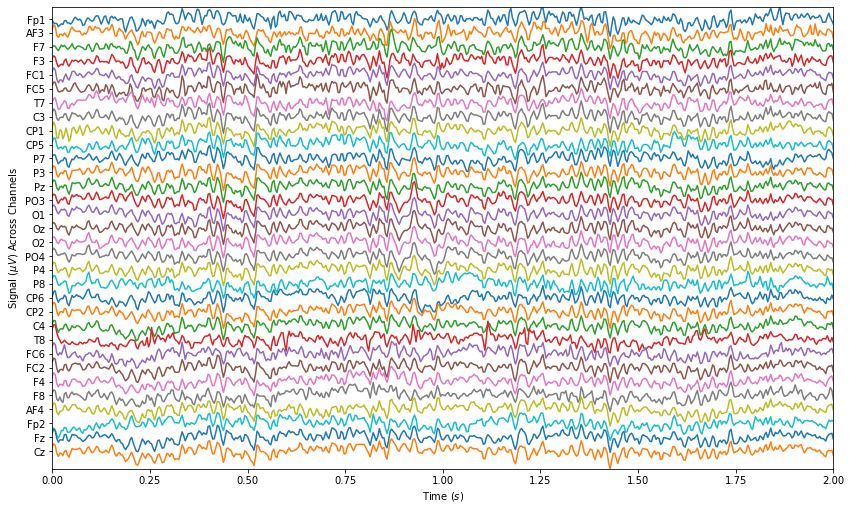

In [10]:
train_data.plot_trace(0)

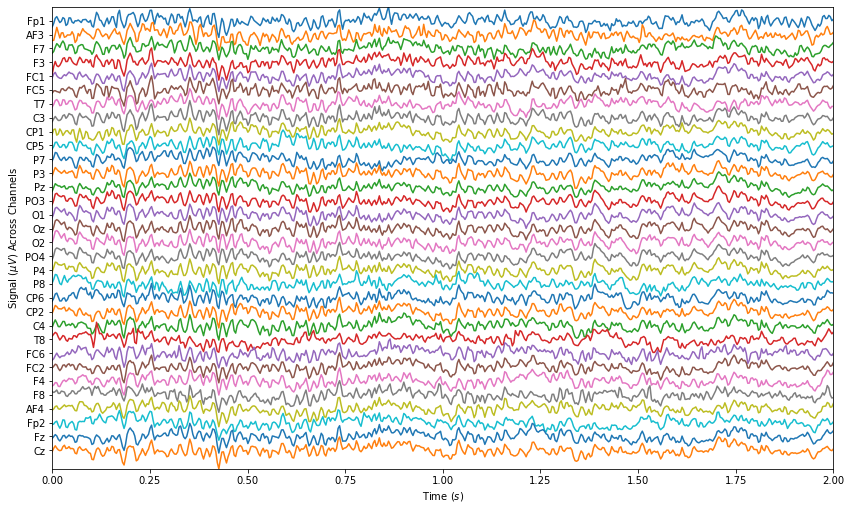

In [11]:
train_data.plot_trace(1)

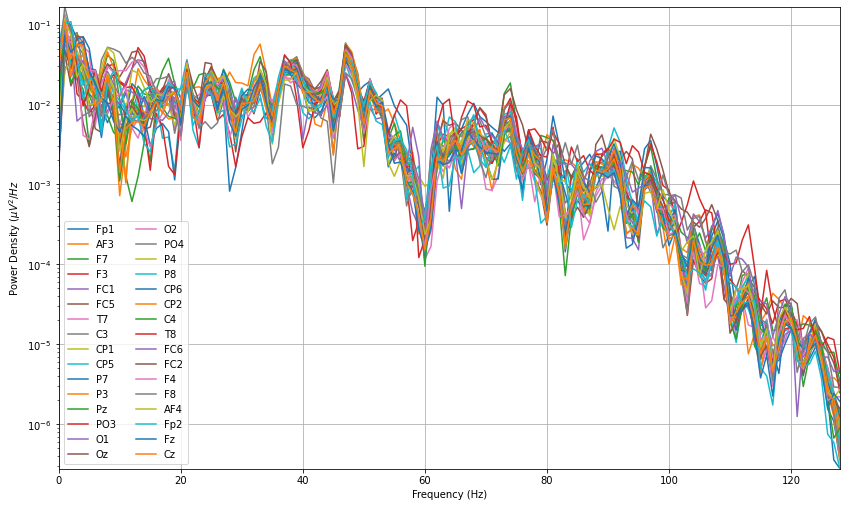

In [12]:
train_data.plot_psd(0)

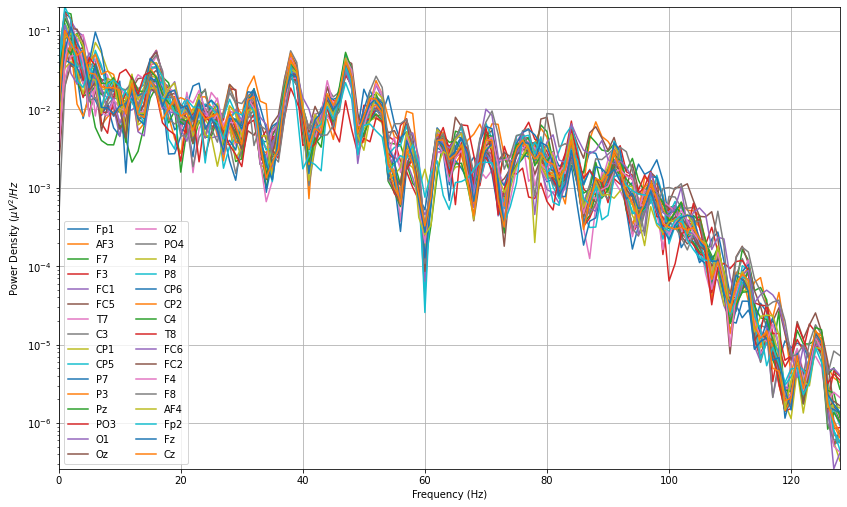

In [13]:
train_data.plot_psd(1)

In [14]:
class EncodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer):
        super().__init__()
        
        self.batch_norm = th.nn.BatchNorm1d(
            nchan, momentum=0.05)
        
        if nchan == nfilt:
            self.resid = lambda segs: segs[:, :, ::stride]
        else:
            self.resid = th.nn.Conv1d(
                nchan, nfilt,
                kernel_size=1,
                padding=0,
                stride=stride)
        
        self.conv = th.nn.Conv1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)
        
        self.transfer = transfer()
        
    def forward(self, segs):
        assert segs.ndim == 3
        
        norm_segs = self.batch_norm(segs)
        resid_out = self.resid(norm_segs)
        conv_out = self.transfer(self.conv(norm_segs))
        
        assert resid_out.shape == conv_out.shape
        return resid_out + conv_out

In [15]:
class Encoder(th.nn.Module):
    def __init__(self, nchan, nstep, conv_specs, transfer=th.nn.ReLU):
        super().__init__()
        
        self.nchan, self.nstep = nchan, nstep

        self.output_shapes = [(nchan, nstep)]
        self.conv_specs = conv_specs
        
        convs = []
        layer_in, layer_out = None, self.nchan
        for nfilt, kernel_size, stride in self.conv_specs:
            layer_in, layer_out = layer_out, nfilt
        
            convs.append(
                EncodeBlock(
                    layer_in, nfilt,
                    kernel_size=kernel_size,
                    stride=stride,
                    transfer=transfer))
            
            nstep = math.ceil(nstep / stride)
            self.output_shapes.append((layer_out, nstep))
            
        self.conv = th.nn.Sequential(*convs)
        
    def forward(self, segs):
        assert isinstance(segs, th.Tensor)

        assert segs.ndim == 3
        assert segs.shape[1] == self.nchan
        assert segs.shape[2] == self.nstep
        batch_size = segs.shape[0]                                                                  

        conv_out = self.conv(segs)
        assert conv_out.ndim == 3
        assert conv_out.shape[0] == batch_size                                                 
        assert conv_out.shape[1] == self.output_shapes[-1][0] # nfilt
        assert conv_out.shape[2] == self.output_shapes[-1][1] # nstep

        codes = conv_out.reshape(batch_size, -1)
        assert codes.ndim == 2
        assert codes.shape[0] == batch_size
        
        return codes

In [16]:
class DecodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer, output_shape):
        super().__init__()
        self.output_shape = output_shape
        
        self.batch_norm = th.nn.BatchNorm1d(
            nchan, momentum=0.05)

        if nchan == nfilt:
            self.resid = lambda segs: segs
        else:
            self.resid = th.nn.Conv1d(nchan, nfilt, kernel_size=1)

        if stride == 1:
            self.upsample = lambda segs: segs
        else:
            self.upsample = th.nn.Upsample(size=self.output_shape, mode='nearest')
            
        self.deconv = th.nn.ConvTranspose1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)
        
        self.transfer = transfer()
        
    def forward(self, segs):
        assert segs.ndim == 3
        
        norm_segs = self.batch_norm(segs)
        resid_out = self.upsample(self.resid(norm_segs))
        deconv_out = self.transfer(self.deconv(norm_segs, self.output_shape))

        assert resid_out.shape == deconv_out.shape
        return resid_out + deconv_out

In [17]:
class Decoder(th.nn.Module):
    def __init__(self, output_shapes, conv_specs, transfer=th.nn.ReLU):
        super().__init__()
        
        self.output_shapes = output_shapes
        self.conv_specs = conv_specs
        
        deconvs = []
        layer_in, layer_out = None, output_shapes[0][0]
        for i, (nfilt, kernel_size, stride) in enumerate(self.conv_specs):
            layer_in, layer_out = layer_out, nfilt

            deconvs.append(
                DecodeBlock(
                    layer_in, nfilt,
                    kernel_size=kernel_size,
                    stride=stride,
                    transfer=transfer,
                    output_shape=self.output_shapes[i+1][1:]))

        self.deconv = th.nn.Sequential(*deconvs)
        
        nchan, _nstep = self.output_shapes[-1]
        self.readout = th.nn.Sequential(                                                            
            th.nn.BatchNorm1d(layer_out, momentum=0.05),                                                           
            th.nn.Conv1d(layer_out, nchan, kernel_size=1, padding=0))
    
    def forward(self, codes):
        assert isinstance(codes, th.Tensor)
        assert codes.ndim == 2
        batch_size = codes.shape[0]
                                                                                                    
        unflat_codes = codes.reshape((batch_size,) + self.output_shapes[0])
        assert unflat_codes.ndim == 3
        assert unflat_codes.shape[0] == batch_size
        assert unflat_codes.shape[1] == self.output_shapes[0][0] # nfilt
        assert unflat_codes.shape[2] == self.output_shapes[0][1] # nstep

        deconv_out = self.deconv(unflat_codes)                         
        assert deconv_out.ndim == 3
        assert deconv_out.shape[0] == batch_size
        assert deconv_out.shape[2] == self.output_shapes[-1][1] # nstep

        segs = self.readout(deconv_out)
        assert segs.ndim == 3
        assert segs.shape[0] == batch_size
        assert segs.shape[1] == self.output_shapes[-1][0] # nchan
        assert segs.shape[2] == self.output_shapes[-1][1] # nstep

        return segs

In [18]:
class Autoencoder(th.nn.Module):
    def __init__(self, nchan, nstep, conv_specs, transfer=th.nn.ReLU):
        super().__init__()

        assert nchan > 0
        assert nstep > 0
        self.nchan, self.nstep = nchan, nstep
        
        assert isinstance(conv_specs, tuple)
        self.conv_specs = conv_specs

        assert issubclass(transfer, th.nn.Module)
                                                                                            
        self.encoder = Encoder(
            nchan=self.nchan,
            nstep=self.nstep,
            conv_specs=self.conv_specs,
            transfer=transfer)

        rev_conv_specs = tuple(reversed(self.conv_specs))
        rev_output_shapes = tuple(reversed(self.encoder.output_shapes))
                                                                                                    
        self.decoder = Decoder(
            output_shapes=rev_output_shapes,
            conv_specs=rev_conv_specs,
            transfer=transfer)
                                                                                                                                                                                                        
    def forward(self, segs):                                                                        
        return self.decoder(self.encoder(segs))                                                     

    def recon(self, segs):
        return self(segs).detach()

In [19]:
def train(model, train_data, valid_data, max_epochs=100, stop_epochs=20,
          learning_rate=0.00175, learning_rate_decay=0.996, clip_norm=6,
          batch_size=256, load_workers=0, use_gpu=True):

        train_loader = th.utils.data.DataLoader(
            train_data,
            batch_size=batch_size,
            pin_memory=use_gpu,
            num_workers=load_workers,
            drop_last=True,
            shuffle=True)

        valid_loader = th.utils.data.DataLoader(
            valid_data,
            batch_size=batch_size,
            pin_memory=use_gpu,
            num_workers=load_workers,
            shuffle=False)

        if use_gpu:
            model.cuda()

        loss_func = th.nn.MSELoss(reduction='mean')

        train_losses = []
        valid_losses = []

        best_train_loss = float('inf')
        best_valid_loss = float('inf')
        best_epoch = 0
        best_state = None

        # all parameters with `requires_grad` set
        parameters = list(filter(lambda param: param.requires_grad, model.parameters()))
        
        # initialize the optimizer
        optimizer = th.optim.Adam(parameters, lr=learning_rate)
        
        # exponential learning rate decay
        lr_scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer, learning_rate_decay)
        
        for epoch in range(max_epochs):                                                                                                    
            # enter training mode
            model.train()

            # training pass
            epoch_train_losses = []
            for i, segs in enumerate(train_loader):
                optimizer.zero_grad()

                if use_gpu:
                    segs = segs.cuda()

                recons = model(segs)
                loss = loss_func(recons, segs)

                loss_f = loss.item()
                epoch_train_losses.append(loss_f)

                loss.backward()

                if clip_norm is not None:
                    th.nn.utils.clip_grad_norm_(parameters, clip_norm)

                optimizer.step()

            train_losses.append(np.mean(epoch_train_losses))
            
            # back to evaluation mode
            model.eval()

            # validation loss
            with th.no_grad():
                epoch_valid_losses = []
                for i, segs in enumerate(valid_loader):
                    if use_gpu:
                        segs = segs.cuda()

                    recons = model(segs)
                    loss = loss_func(recons, segs)

                    loss_f = loss.item()
                    epoch_valid_losses.append(loss_f)

            valid_losses.append(np.mean(epoch_valid_losses))
            
            if valid_losses[-1] < best_valid_loss:
                best_train_loss = train_losses[-1]
                best_valid_loss = valid_losses[-1]
                best_epoch = epoch
                best_state = model.state_dict()

            print('epoch:', epoch)
            print('learning rate:', next(iter(optimizer.param_groups))['lr'])
            print('train loss:', train_losses[-1])
            print('valid loss:', valid_losses[-1])
            print('best epoch:', best_epoch)
            print('=======')
                
            if (best_epoch + stop_epochs) <= epoch:
                print(f'terminating after {stop_epochs} of no improvement')
                break

            lr_scheduler.step()

        if best_state is None:
            raise RuntimeError('best state not set!')

        model.load_state_dict(best_state)

        if use_gpu:
            model.cpu()

        return munch.munchify({
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'best_train_loss': best_train_loss,
            'best_valid_loss': best_valid_loss,
            'best_epoch': best_epoch,
        })

In [20]:
autoencoder = Autoencoder(
    nchan=train_data.nchan,
    nstep=train_data.nstep,
    #conv_specs=((48, 5, 1), (48, 5, 1), (48, 5, 2),
    #            (64, 5, 1), (64, 5, 1), (64, 5, 2),
    #            (80, 5, 1), (80, 5, 1), (80, 5, 2),
    #            (96, 5, 1), (96, 5, 1), (96, 5, 2),
    #            (112, 5, 1), (112, 5, 1), (112, 5, 2),),
    #conv_specs=((48, 11, 1), (48, 11, 2),
    #            (56,  9, 1), (56,  9, 2),
    #            (64,  7, 1), (64,  7, 2),
    #            (72,  5, 1), (72,  5, 2),
    #            (80,  3, 1), (80,  3, 2)),
    #conv_specs=(
    #    (32, 5, 1), (32, 5, 1), (32, 5, 1), (32, 5, 2),
    #    (40, 5, 1), (40, 5, 1), (40, 5, 1), (40, 5, 2),
    #    (48, 5, 1), (48, 5, 1), (48, 5, 1), (48, 5, 2),
    #    (56, 5, 1), (56, 5, 1), (56, 5, 1), (56, 5, 2)),
    conv_specs=((48, 23, 2), (64, 19, 2), (80, 15, 2), (96, 11, 2),),
    #conv_specs=((40, 23, 2), (48, 19, 2), (56, 15, 2), (64, 11, 2)),
    #conv_specs=((40, 23, 2), (48, 19, 2), (56, 15, 2), (64, 11, 2), (72, 7, 2)),
    transfer=th.nn.ReLU)

autoencoder

Autoencoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): EncodeBlock(
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
        (resid): Conv1d(32, 48, kernel_size=(1,), stride=(2,))
        (conv): Conv1d(32, 48, kernel_size=(23,), stride=(2,), padding=(11,))
        (transfer): ReLU()
      )
      (1): EncodeBlock(
        (batch_norm): BatchNorm1d(48, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
        (resid): Conv1d(48, 64, kernel_size=(1,), stride=(2,))
        (conv): Conv1d(48, 64, kernel_size=(19,), stride=(2,), padding=(9,))
        (transfer): ReLU()
      )
      (2): EncodeBlock(
        (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
        (resid): Conv1d(64, 80, kernel_size=(1,), stride=(2,))
        (conv): Conv1d(64, 80, kernel_size=(15,), stride=(2,), padding=(7,))
        (transfer): ReLU()
      )
      (3): EncodeBlock(
        (b

In [21]:
sum(p.nelement() for p in autoencoder.parameters())

676608

In [22]:
first_segment = train_data[0]

In [23]:
first_segment.shape, first_segment.shape[0] * first_segment.shape[1]

(torch.Size([32, 512]), 16384)

In [24]:
autoencoder.eval()
autoencoder.encoder(first_segment[None, ...]).shape

torch.Size([1, 3072])

In [25]:
autoencoder.encoder.output_shapes

[(32, 512), (48, 256), (64, 128), (80, 64), (96, 32)]

In [26]:
recon = autoencoder.recon(first_segment[None, ...])
recon.shape, recon.min(), recon.max()

(torch.Size([1, 32, 512]), tensor(-0.3858), tensor(0.2860))

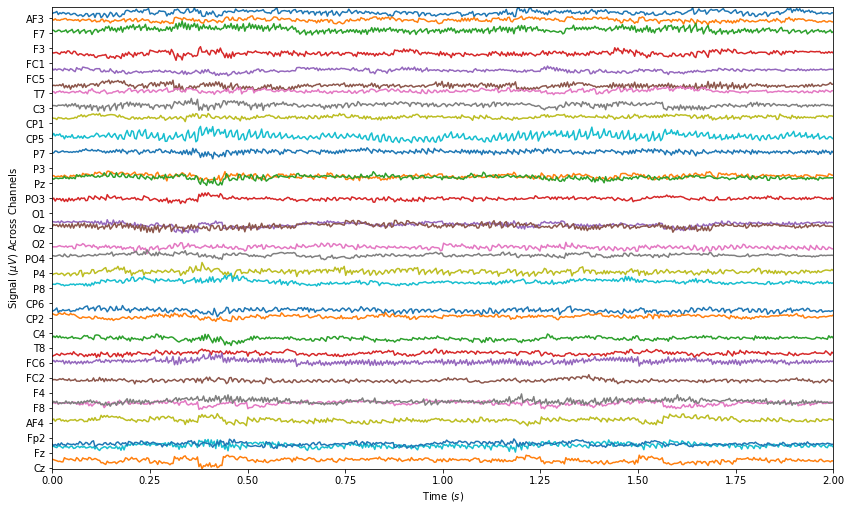

In [27]:
train_data.plot_trace(recon[0])

In [28]:
train_result = train(autoencoder, train_data, valid_data, max_epochs=500)

epoch: 0
learning rate: 0.00175
train loss: 0.555182445794344
valid loss: 0.6357631285985311
best epoch: 0
epoch: 1
learning rate: 0.001743
train loss: 0.39899889305233954
valid loss: 0.30835136274496716
best epoch: 1
epoch: 2
learning rate: 0.001736028
train loss: 0.3319829322397709
valid loss: 0.2582097500562668
best epoch: 2
epoch: 3
learning rate: 0.0017290838879999999
train loss: 0.30172829478979113
valid loss: 0.24214633305867514
best epoch: 3
epoch: 4
learning rate: 0.0017221675524479998
train loss: 0.27212877981364725
valid loss: 0.22297981133063635
best epoch: 4
epoch: 5
learning rate: 0.0017152788822382078
train loss: 0.24127233549952506
valid loss: 0.20148354768753052
best epoch: 5
epoch: 6
learning rate: 0.001708417766709255
train loss: 0.21826789975166322
valid loss: 0.18879753599564233
best epoch: 6
epoch: 7
learning rate: 0.001701584095642418
train loss: 0.20429384373128415
valid loss: 0.17940273135900497
best epoch: 7
epoch: 8
learning rate: 0.0016947777592598483
train 

epoch: 62
learning rate: 0.0013649509054516468
train loss: 0.07134487461298704
valid loss: 0.061551972602804504
best epoch: 62
epoch: 63
learning rate: 0.0013594911018298401
train loss: 0.07087699249386788
valid loss: 0.06214779677490393
best epoch: 62
epoch: 64
learning rate: 0.0013540531374225209
train loss: 0.0708422914147377
valid loss: 0.06174523880084356
best epoch: 62
epoch: 65
learning rate: 0.0013486369248728307
train loss: 0.07055660989135504
valid loss: 0.06042157610257467
best epoch: 65
epoch: 66
learning rate: 0.0013432423771733394
train loss: 0.07016660831868649
valid loss: 0.05968745735784372
best epoch: 66
epoch: 67
learning rate: 0.001337869407664646
train loss: 0.06984287109225988
valid loss: 0.05951717992623647
best epoch: 67
epoch: 68
learning rate: 0.0013325179300339874
train loss: 0.06934101171791554
valid loss: 0.059253253042697906
best epoch: 68
epoch: 69
learning rate: 0.0013271878583138515
train loss: 0.06883886810392141
valid loss: 0.05826457031071186
best ep

epoch: 123
learning rate: 0.0010688990099215552
train loss: 0.05942651852965355
valid loss: 0.04954268286625544
best epoch: 121
epoch: 124
learning rate: 0.001064623413881869
train loss: 0.059277366194874045
valid loss: 0.04940710589289665
best epoch: 121
epoch: 125
learning rate: 0.0010603649202263416
train loss: 0.05908466326072812
valid loss: 0.049492318804065384
best epoch: 121
epoch: 126
learning rate: 0.0010561234605454362
train loss: 0.0592009412124753
valid loss: 0.049628576884667076
best epoch: 121
epoch: 127
learning rate: 0.0010518989667032545
train loss: 0.05902694631367922
valid loss: 0.0493813119828701
best epoch: 121
epoch: 128
learning rate: 0.0010476913708364415
train loss: 0.05910222390666604
valid loss: 0.049359252055486046
best epoch: 121
epoch: 129
learning rate: 0.0010435006053530957
train loss: 0.05898178545758128
valid loss: 0.04909805084268252
best epoch: 129
epoch: 130
learning rate: 0.0010393266029316832
train loss: 0.058946200832724574
valid loss: 0.05037777

epoch: 184
learning rate: 0.0008370594787313799
train loss: 0.056660678889602425
valid loss: 0.047878289595246315
best epoch: 176
epoch: 185
learning rate: 0.0008337112408164543
train loss: 0.056502063386142255
valid loss: 0.048129901910821594
best epoch: 176
epoch: 186
learning rate: 0.0008303763958531885
train loss: 0.056573239900171754
valid loss: 0.04767447399596373
best epoch: 176
epoch: 187
learning rate: 0.0008270548902697758
train loss: 0.056626287568360564
valid loss: 0.048111925522486367
best epoch: 176
epoch: 188
learning rate: 0.0008237466707086967
train loss: 0.056534044537693263
valid loss: 0.04786047339439392
best epoch: 176
epoch: 189
learning rate: 0.0008204516840258619
train loss: 0.05646991701796651
valid loss: 0.04790832350651423
best epoch: 176
epoch: 190
learning rate: 0.0008171698772897585
train loss: 0.056334784161299466
valid loss: 0.04756453881661097
best epoch: 190
epoch: 191
learning rate: 0.0008139011977805994
train loss: 0.056243942305445674
valid loss: 0.

In [29]:
with open('eeg_autoencoder1.pkl', mode='wb') as fh:                                                  
    th.save(autoencoder.state_dict(), fh)

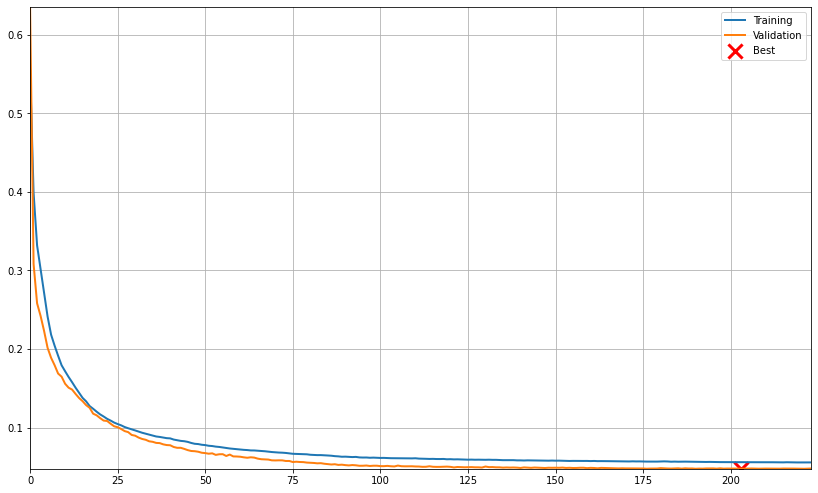

In [30]:
fig_loss = plt.figure()
ax_loss = fig_loss.add_subplot(1, 1, 1)
ax_loss.plot(train_result.train_losses, linewidth=2, label='Training')
ax_loss.plot(train_result.valid_losses, linewidth=2, label='Validation')
ax_loss.scatter(
    (train_result.best_epoch,), (train_result.best_valid_loss,),
    linewidth=3, s=200, marker='x', color='red', label='Best')
ax_loss.legend()
ax_loss.autoscale(tight=True)
ax_loss.grid();

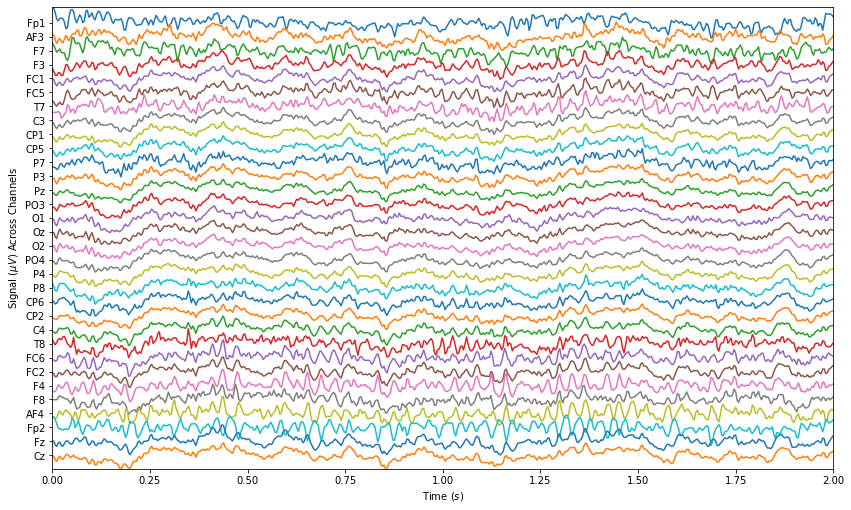

In [31]:
first_segment = valid_data[0]
valid_data.plot_trace(first_segment)

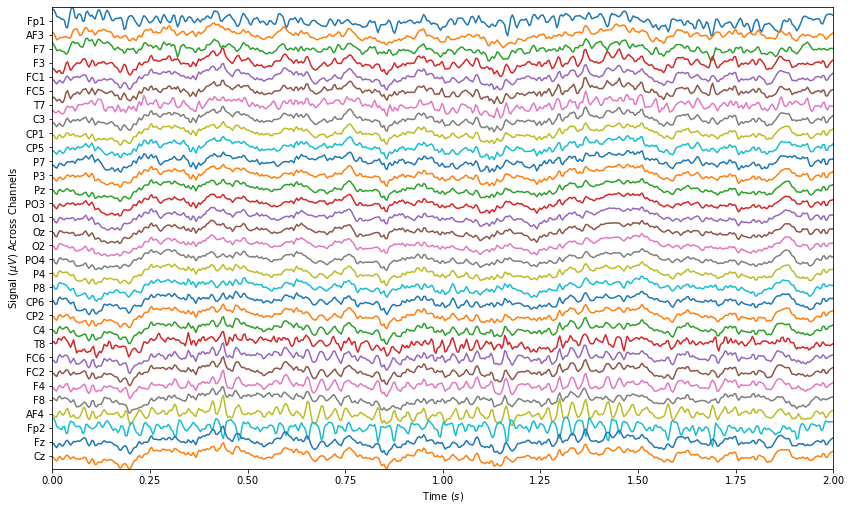

In [32]:
recon = autoencoder.recon(first_segment[None, ...])
valid_data.plot_trace(recon[0])

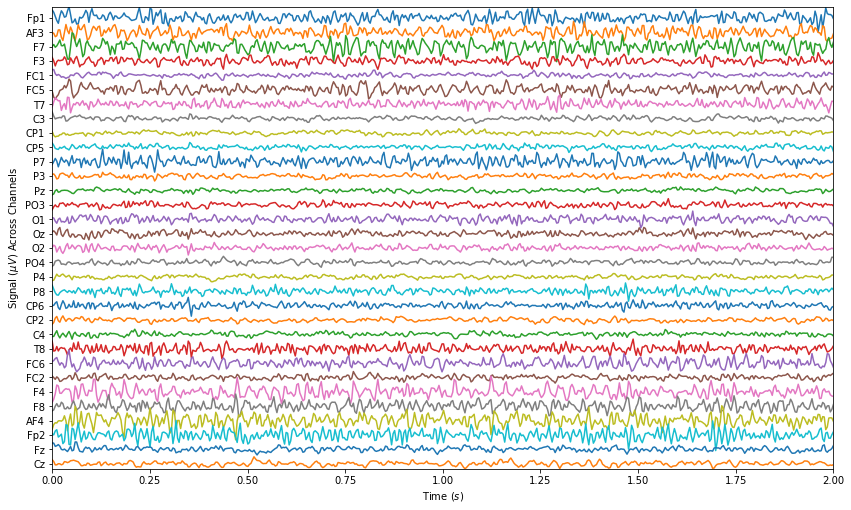

In [39]:
valid_data.plot_trace(first_segment - recon[0])

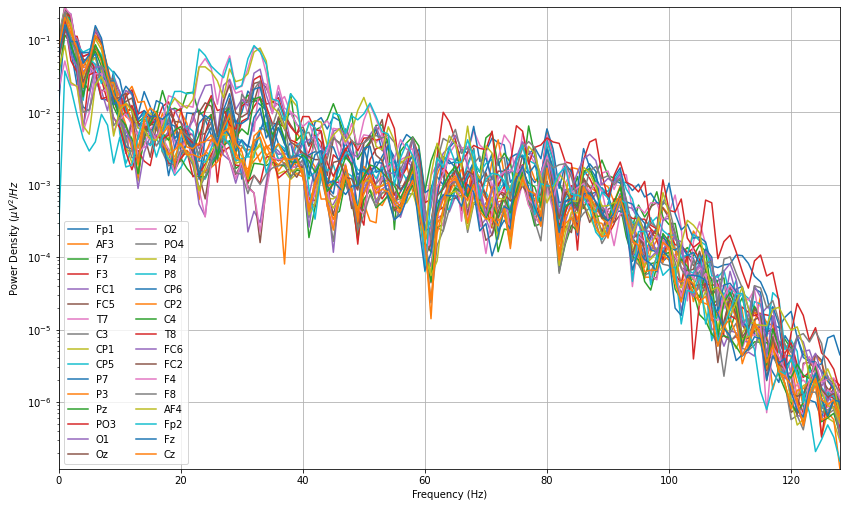

In [33]:
valid_data.plot_psd(first_segment)

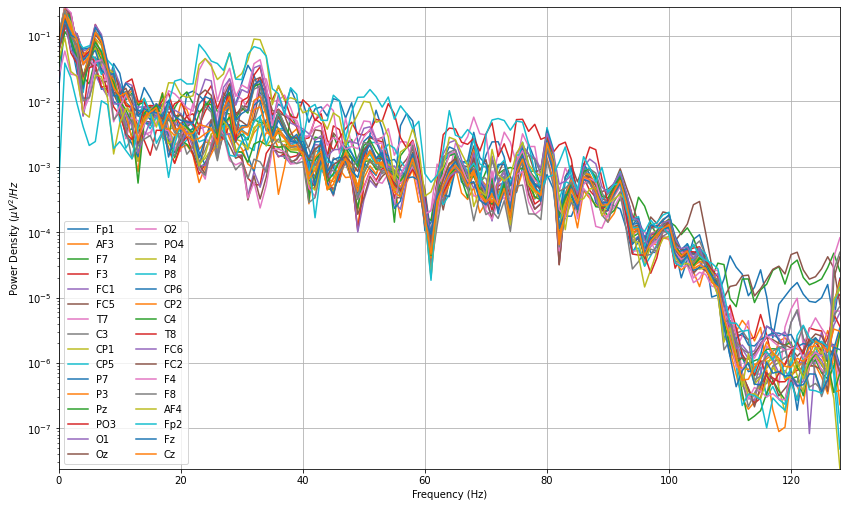

In [34]:
valid_data.plot_psd(recon[0])

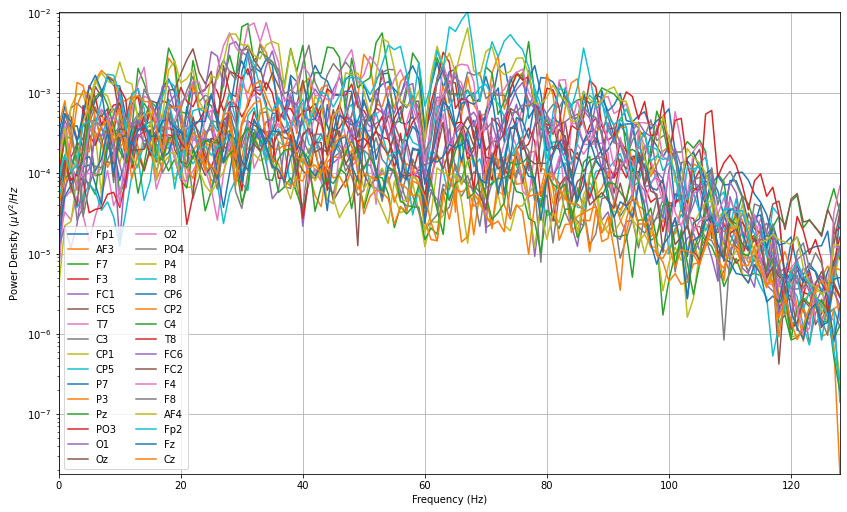

In [40]:
valid_data.plot_psd(first_segment - recon[0])

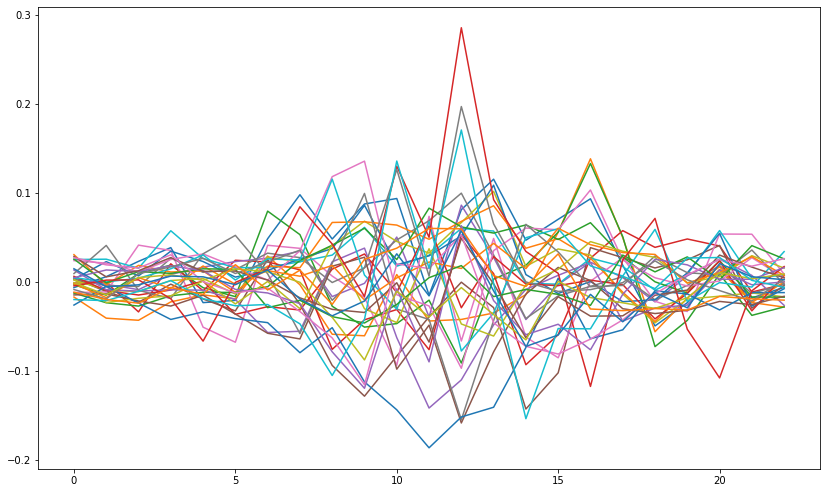

In [35]:
plt.plot(autoencoder.encoder.conv[0].conv.weight[0].detach().T);

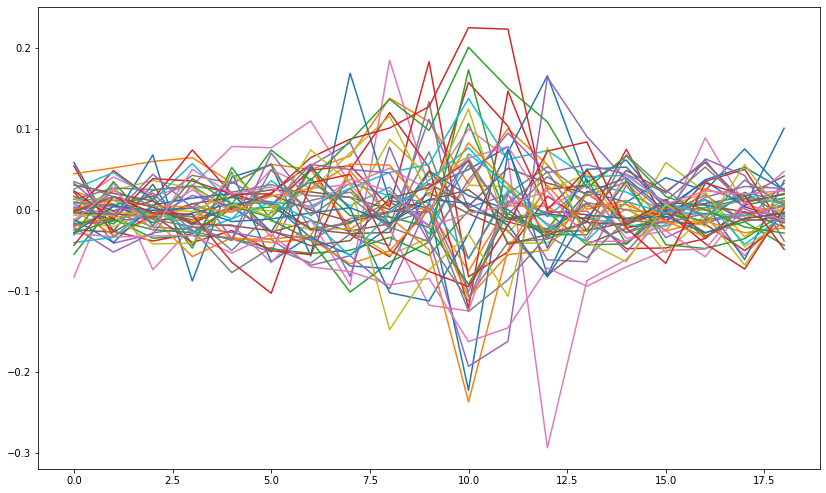

In [36]:
plt.plot(autoencoder.encoder.conv[1].conv.weight[0].detach().T);

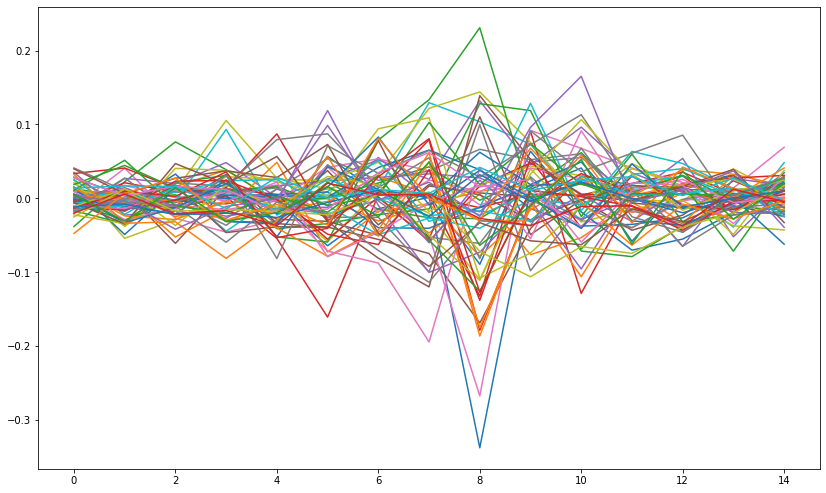

In [37]:
plt.plot(autoencoder.encoder.conv[2].conv.weight[0].detach().T);